In [1]:
import modelo as m
import pandas as pd
import Bio.KEGG.REST as rkg
import Bio.KEGG.Enzyme as ex
import networkx as nx
import cufflinks as cf
import pylab as pl
import numpy as np
import plotly.tools as tls
from plotly.graph_objs import *
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
from matplotlib import pyplot as plt
from plotly.offline import *
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize

import random

random.seed(42)

init_notebook_mode(connected=True)

In [2]:
def roc(X_train, y_train, X_test, y_test, mean_fpr, aucs, tprs, cls, l):
    i = 0
    for c in cls:
        probas_ = c.fit(X_train, y_train).predict_proba(X_test)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(label_binarize(y_test, classes=[0, 1]), probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC %s (AUC = %0.2f)' % (l[i], roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    return(plt)

In [3]:
eco = pd.read_csv("data/ecoli_all.csv")
mge = pd.read_csv("data/mgenitalium_all.csv")
pae = pd.read_csv("data/paeruginosa_all.csv")
sce = pd.read_csv("data/scerevisiae_all.csv")

In [4]:
eco_x, eco_y = eco.iloc[:,2:-1],eco['class']
mge_x, mge_y = mge.iloc[:,2:-1],mge['class']
pae_x, pae_y = pae.iloc[:,2:-1],pae['class']
sce_x, sce_y = sce.iloc[:,2:-1],sce['class']

In [5]:
sce_y.replace(1,0, inplace=True)
sce_y.replace(2,1, inplace=True)
sce_y.replace(3,1, inplace=True)
eco_y.replace(1,0, inplace=True)
eco_y.replace(2,1, inplace=True)
eco_y.replace(3,1, inplace=True)
pae_y.replace(1,0, inplace=True)
pae_y.replace(2,1, inplace=True)
pae_y.replace(3,1, inplace=True)
mge_y.replace(1,0, inplace=True)
mge_y.replace(2,1, inplace=True)
mge_y.replace(3,1, inplace=True)

## SVM Parameter Selection 

In [6]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

#parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1]}
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1]}
svc = svm.SVC(probability=True)
grid = GridSearchCV(svc, parameters)
rand = RandomizedSearchCV(svc, parameters)

classifiers = [grid, rand]
cls = ['GridSearchCV', 'RandomizedSearchCV']

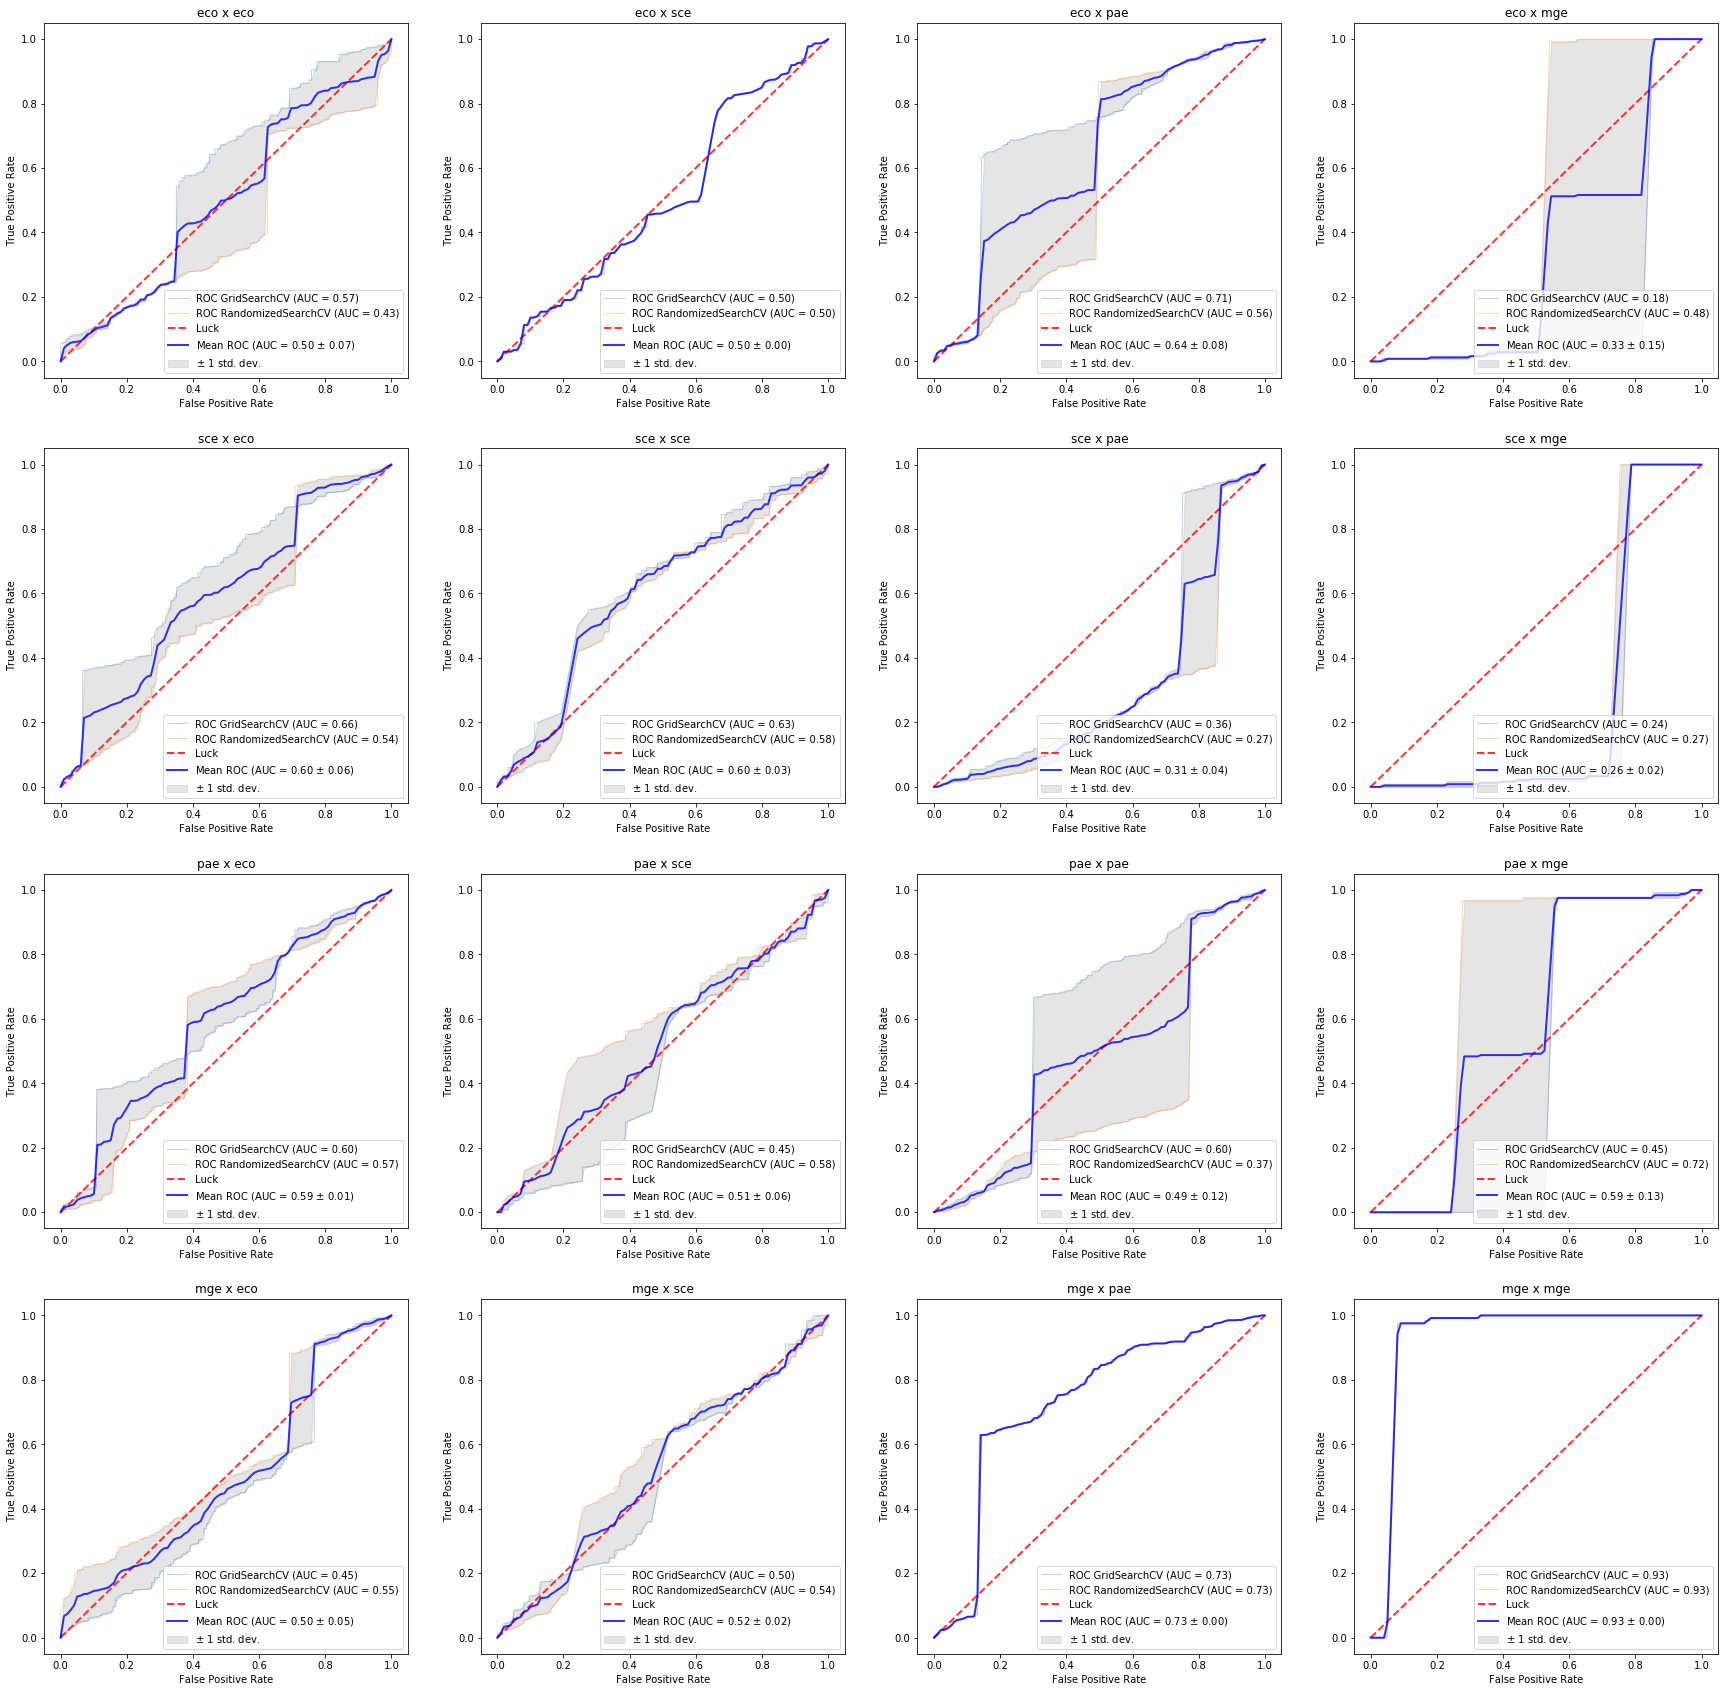

In [8]:
fig = plt.figure(figsize=(30,30))
pcount = 1
row = 4
col = 4
for i in [(eco_x,eco_y,'eco'),(sce_x,sce_y,'sce'),(pae_x,pae_y,'pae'),(mge_x,mge_y,'mge')]:
    for j in [(eco_x,eco_y,'eco'),(sce_x,sce_y,'sce'),(pae_x,pae_y,'pae'),(mge_x,mge_y,'mge')]:
        tprs_dall = []
        aucs_dall = []
        mean_fpr_dall = np.linspace(0, 1, 100)
        a = fig.add_subplot(row, col, pcount)
        imgshow = roc(i[0],i[1],j[0],j[1], mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
        a.set_title(i[2]+" x "+j[2])
        pcount+=1

plt.show()

In [ ]:
fig = plt.figure(figsize=(20,20))

tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)

train_x = pd.concat([sce_x,mge_x,pae_x])
train_y = pd.concat([sce_y,mge_y,pae_y])
test_x = eco_x 
test_y = eco_y

fs = SelectKBest(chi2, k=7).fit(train_x, train_y)
train_x = train_x.iloc[:, fs.get_support()]
test_x = test_x.iloc[:, fs.get_support()]

a = fig.add_subplot(2, 2, 1)
imgshow = roc(train_x, train_y, test_x, test_y, mean_fpr_dall, aucs_dall, tprs_dall, classifiers, cls)
a.set_title("all x eco")
#-----------------------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)

train_x = pd.concat([eco_x,sce_x,pae_x])
train_y = pd.concat([eco_y,sce_y,pae_y])
test_x = mge_x 
test_y = mge_y

fs = SelectKBest(chi2, k=7).fit(train_x, train_y)
train_x = train_x.iloc[:, fs.get_support()]
test_x = test_x.iloc[:, fs.get_support()]

a = fig.add_subplot(2, 2, 2)
imgshow = roc(train_x, train_y, test_x, test_y, mean_fpr_dall, aucs_dall, tprs_dall, classifiers, cls)
a.set_title("all x mge")
#-----------------------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)

train_x = pd.concat([eco_x,sce_x,mge_x])
train_y = pd.concat([eco_y,sce_y,mge_y])
test_x = pae_x 
test_y = pae_y

fs = SelectKBest(chi2, k=7).fit(train_x, train_y)
train_x = train_x.iloc[:, fs.get_support()]
test_x = test_x.iloc[:, fs.get_support()]

a = fig.add_subplot(2, 2, 3)
imgshow = roc(train_x, train_y, test_x, test_y, mean_fpr_dall, aucs_dall, tprs_dall, classifiers, cls)
a.set_title("all x pae")
#-----------------------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)

train_x = pd.concat([eco_x,mge_x,pae_x])
train_y = pd.concat([eco_y,mge_y,pae_y])
test_x = sce_x 
test_y = sce_y

fs = SelectKBest(chi2, k=7).fit(train_x, train_y)
train_x = train_x.iloc[:, fs.get_support()]
test_x = test_x.iloc[:, fs.get_support()]

a = fig.add_subplot(2, 2, 4)
imgshow = roc(train_x, train_y, test_x, test_y, mean_fpr_dall, aucs_dall, tprs_dall, classifiers, cls)
a.set_title("all x sce")

plt.show()